In [101]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import math

In [102]:
class Gaussian:
    def __init__(self, width, amplitude, x0):
        self.width = width
        self.amplitude = amplitude
        self.x0 = x0
        
    def __call__(self, x):
        A = self.amplitude
        x0 = self.x0
        sigma = self.width
        return A*np.exp(-((x[0]-x0[0])**2 + (x[1]-x0[1])**2)/sigma**2)

In [103]:
class propagate:
    def __init__(self, Lx, Nx, Ly, Ny, Lz, Nz, k, K, init_f, non_f):
        self.Lx = Lx
        self.Nx = Nx
        self.Ly = Ly
        self.Ny = Ny
        self.Lz = Lz
        self.Nz = Nz
        self.k = k
        self.K = K
        self.non_f = non_f
        
        #We can reduce the code by using step parameter in linspace
        
        self.dz = Lz/Nz
        self.dx = Lx/Nx
        self.dy = Ly/Ny
        self.matrix = np.zeros([Nz, 2*Nx, 2*Ny])
        
        kx = 2*np.pi*np.fft.fftfreq(2*Nx, d=self.dx)
        ky = 2*np.pi*np.fft.fftfreq(2*Ny, d=self.dy)
        kxy2 = np.zeros([2*Nx, 2*Ny])
        
        for i in range(2*Nx):
            for j in range(2*Ny):
                kxy2[i][j] = kx[i]**2 + ky[j]**2
        self.kxy2 = kxy2
                
        self.x = np.linspace(-Lx, Lx, 2*Nx)
        self.y = np.linspace(-Ly, Ly, 2*Ny)
        E = np.zeros([2*Nx, 2*Ny])
        
        #intialisation
        for i in range(2*Nx):
            for j in range(2*Ny):
                x0 =(2*Lx)/(2*Nx-1)*i - Lx
                x1 =(2*Ly)/(2*Ny-1)*j - Ly
                E[i][j] = init_f([x0, x1])
        
        self.E = E
        self.matrix[0,:,:] = E
        
    def evolution(self):
        list_z =[]
        list_z1 = []
        E = self.E*(1+1j*0)
        list_z.append(np.abs(E)**2)
        list_z1.append(E)
        
        for l in range(Nz-1):
            '''
            #solve for non-linear
            c = np.exp(1j*self.non_f(E)*self.dz)*E
            c = np.fft.fft2(c)
            c *= np.exp(-1j/(2*self.k)*(self.kxy2)*self.dz)
            E = np.fft.ifft2(c)
            
            '''
            #Linear
            Ek = np.fft.fft2(E)
            Ek *= np.exp(-1j/(2*self.k)*(self.kxy2)*self.dz)
            E = np.fft.ifft2(Ek)
            #print(np.abs(E)/list_z[-1])
        
            #Non-linear
            #print(non_f(E)*self.dz/E)
            #if l == 0: E += non_f(E)*self.dz
            #else: E += (3/2)*non_f(list_z1[-1])*self.dz - (1/2)*non_f(list_z1[-2])*self.dz
            E += non_f(E)*self.dz
            
            #Putting into list
            list_z.append(np.abs(E)**2)
            list_z1.append(E)
        
        list_z = np.asarray(list_z)
        self.matrix = list_z
        

In [104]:
cross = 5.1*1e-24
light = 3*1e8
lamb = 790*1e-9
omega = 2*np.pi*light/lamb
tau = 3.5*1e-13
beta = 6.5*1e-104
hbar = 6.62*1e-34
tp = 200*1e-15
f = 1/2
n2 = 5.57*1e-23
k = 2*np.pi/775*1e9
K = 7

const1 = -cross/2*(1 + omega*tau)*beta/(K*hbar*omega)*tp/(8*K)**(1/2)
const2 = -beta/2
const3 = 1j*omega/light*(1-f)*n2

def non_f(E):
    const1 = -cross/2*(1 + omega*tau)*beta/(K*hbar*omega)*tp/(8*K)**(1/2)
    const2 = -beta/2
    const3 = 1j*omega/light*(1-f)*n2
    return const1*E*np.abs(E)**(2*K) + const2*E*np.abs(E)**(2*K - 2) + const3*E*np.abs(E)**2


C:\Users\Hong\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


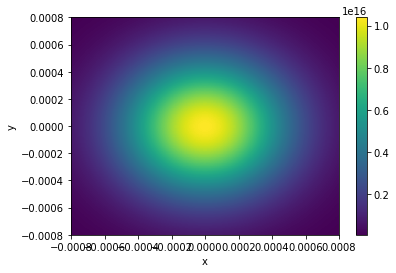

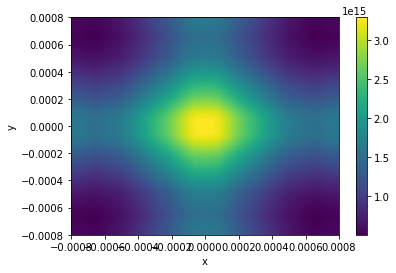

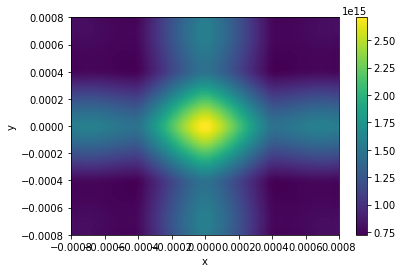

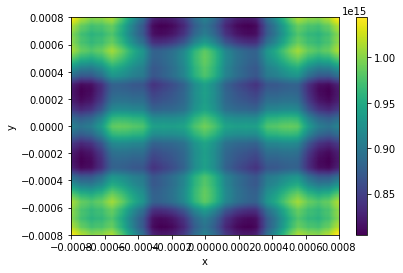

In [105]:
w0 = 0.7*1e-3
Pcr = 2*1e9
p = 4
Pin = p*Pcr
AMP = (2*Pin/(math.pi*w0**2))**(1/2)
x0 = [0., 0.]

gauss = Gaussian(w0, AMP, x0)

Lx = 800*1e-6
Nx = 256
Ly = 800*1e-6
Ny = 256
Lz = 1.4
Nz = 512

init_f = gauss

laser = propagate(Lx, Nx, Ly, Ny, Lz, Nz, k, K, init_f, non_f)
laser.evolution()

#for i in range(25):
#    fig, ax = plt.subplots()
#    mesh = ax.pcolormesh(Pro.x, Pro.y, Pro.matrix[i*10])
#    ax.set_xlabel('x')
#    ax.set_ylabel('y')
#    plt.colorbar(mesh, ax=ax)
#    fig.show()

for i in [0, 219, 303, Nz-1]:
    fig, ax = plt.subplots()
    mesh = ax.pcolormesh(laser.x, laser.y, laser.matrix[i])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.colorbar(mesh, ax=ax)
    fig.show()